# 0. 준비

In [1]:
from pathlib import Path

In [ ]:
# import essentia
# import essentia.standard as es

In [2]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
folder = Path('wav_folder')
wav_paths = sorted(folder.glob('*.wav'))

audio_path1, audio_path2, audio_path3 = wav_paths[:3]

print(audio_path1)  # wav_folder/1.wav
print(audio_path2)  # wav_folder/2.wav
print(audio_path3)  # wav_folder/3.wav

# 1. 조성 분포

> 분리된 콘다 환경에서 실행 가능

In [ ]:
# def extract_key_signature(audio_path):
#     loader = es.MonoLoader(filename=str(audio_path))
#     audio = loader()
    
#     key_extractor = es.KeyExtractor()
#     key, scale, strength = key_extractor(audio)
#     return key, scale, strength

In [ ]:
# key, scale, strength = extract_key_signature(audio_path1)

# 2. 템포 변화

In [6]:
def get_onset_tempogram_tempo(audio_path):
  # Load audio
  y, sr = librosa.load(audio_path, duration=30)
  hop_length = 512

  # Onset strength envelope
  oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

  # Tempogram (local autocorrelation)
  tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)
  tempos = librosa.tempo_frequencies(tempogram.shape[0], sr=sr, hop_length=hop_length)

  # Global autocorrelation
  ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
  ac_global = librosa.util.normalize(ac_global)

  # Global tempo estimate
  tempo = librosa.feature.tempo(onset_envelope=oenv, sr=sr, hop_length=hop_length)[0]

  return oenv, tempogram, tempo

In [7]:
def get_dominant_tempo(tempogram, threshold=0.5):

  active_bpm_per_frame = np.sum(tempogram >= threshold, axis=0)
  active_bpm_variance = np.var(active_bpm_per_frame)

  prev_indices = None
  change_counts = 0
  for t in range(tempogram.shape[1]):
      indices = set(np.where(tempogram[:, t] >= threshold)[0])
      if prev_indices is not None:
          change = len(indices.symmetric_difference(prev_indices))
          change_counts += change
      prev_indices = indices
  tempo_transition_complexity = change_counts / tempogram.shape[1]

  return tempo_transition_complexity, active_bpm_variance

In [8]:
oenv, tempogram, tempo = get_onset_tempogram_tempo(audio_path1)
tempo_transition_complexity, active_bpm_variance = get_dominant_tempo(tempogram)
tempo_transition_complexity, active_bpm_variance

(0.17414860681114552, np.float64(326.4930334566612))

# 3. 피치 범위

In [9]:
def get_pitch_range(audio_path):
  y, sr = librosa.load(audio_path, duration=30)

  f0, _, _ = librosa.pyin(
      y,
      fmin=librosa.note_to_hz('C2'),
      fmax=librosa.note_to_hz('C7'),
      sr=sr
  )

  # NaN 제거
  f0 = f0[~np.isnan(f0)]

  # IQR 기반 이상치 제거
  q1 = np.percentile(f0, 25)
  q3 = np.percentile(f0, 75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  f0_filtered = f0[(f0 >= lower_bound) & (f0 <= upper_bound)]
  pitch_range = np.max(f0_filtered) - np.min(f0_filtered)

  return f0_filtered, pitch_range

In [10]:
f0, pitch_range = get_pitch_range(audio_path1)
pitch_range

np.float64(121.74038408403857)

(array([  3.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   5.,   9.,  44.,  83., 188.,
         35.,  11.,   0.,   5.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  11.,   0.,
         62.,  91.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

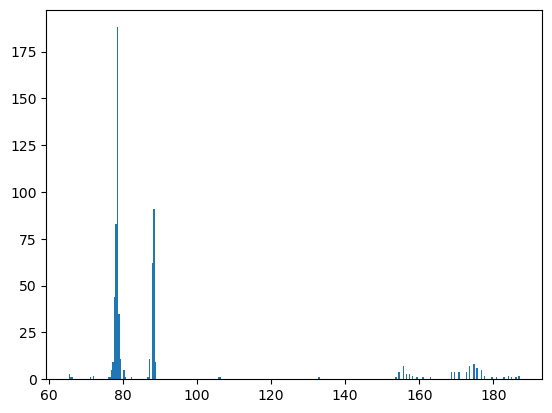

In [11]:
plt.hist(f0, bins=300)

# 4. 반복 구간 비율

In [12]:
def plot_similarity_matrix(similarity_matrix, sr, hop_length):
    plt.figure(figsize=(6, 5))
    librosa.display.specshow(similarity_matrix, x_axis='time', y_axis='time',
                              sr=sr, hop_length=hop_length, cmap='magma')
    plt.title("Self-Similarity Matrix (Chroma Cosine Similarity)")
    plt.colorbar(label='Cosine Similarity')
    plt.tight_layout()
    plt.show()

def check_repetition_ratio(audio_path, threshold=0.8, min_separation_sec=1.0, hop_length=512):
    # 1. Load audio
    y, sr = librosa.load(audio_path, duration=30)

    # 2. Extract chroma feature
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)  # shape: (12, T)

    # 3. Cosine similarity between time frames
    similarity_matrix = cosine_similarity(chroma.T)  # shape: (T, T)
    T = similarity_matrix.shape[0]

    # 4. Minimum diagonal offset (exclude self or very nearby frames)
    min_diag_offset = int(min_separation_sec * sr / hop_length)  # e.g., 1 sec

    time_idx = np.arange(T)
    frame_diff = np.abs(time_idx[:, None] - time_idx[None, :])

    # 5. Valid repeat: high similarity + not too close in time
    is_valid_repeat = (similarity_matrix > threshold) & (frame_diff >= min_diag_offset)

    total_possible = np.sum(frame_diff >= min_diag_offset)
    repeated_area = np.sum(is_valid_repeat)
    repetition_ratio_value = repeated_area / total_possible if total_possible > 0 else 0

    # 6. Print summary
    print(f"Chroma shape: {chroma.shape}")
    print(f"Self-similarity matrix shape: {similarity_matrix.shape}")
    print(f"Repeated area size: {repeated_area}")
    print(f"Repetition ratio: {repetition_ratio_value:.4f}")

    # 7. Plot similarity matrix
    plot_similarity_matrix(similarity_matrix, sr=sr, hop_length=hop_length)

    return repetition_ratio_value

Chroma shape: (12, 1292)
Self-similarity matrix shape: (1292, 1292)
Repeated area size: 468198
Repetition ratio: 0.2999


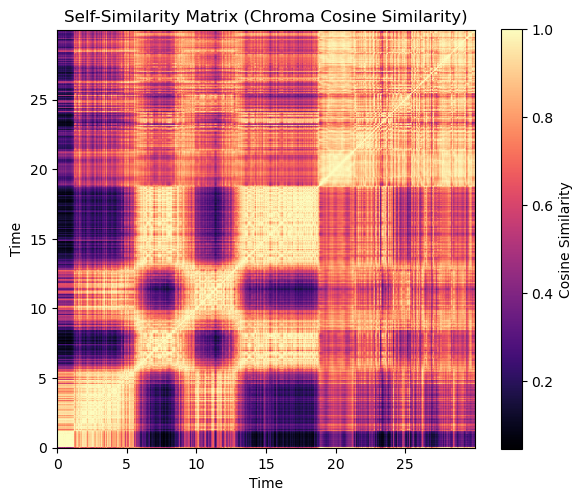

np.float64(0.29988662930344273)

In [13]:
check_repetition_ratio(audio_path1)

# 5. RMS 분산

In [14]:
def check_rms_variation(audio_path):
    y, sr = librosa.load(audio_path, duration=30)

    rms = librosa.feature.rms(y=y).flatten()

    rms = rms[~np.isnan(rms) & ~np.isinf(rms)]

    if len(rms) == 0:
        return 0.0

    rms_var = np.var(rms)
    return rms_var

In [15]:
rms_var = check_rms_variation(audio_path1)
rms_var

np.float32(0.008695843)